In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

print("Added to sys.path:", project_root)

Added to sys.path: c:\Users\eduar\Documents\RDEPro_testing\rdepro_skrub_provenance


In [2]:
# =====================================================
# Brazilian E-Commerce Public Dataset (Olist)
# End-to-End Data Analysis
# =====================================================


"""
Objective:
Analyze Brazilian e-commerce orders to understand delivery performance,
customer satisfaction, and key operational drivers.
"""

# -------------------------------
# 1. Imports & Data Loading
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import skrub
from skrub import ToDatetime
from skrub import TableReport
sns.set(style="whitegrid")
#from skrub._data_ops._provenance import trace_row, explain_provenance

In [3]:
from monkey_patching_v02.data_provenance.monkey_patching_v02_data_provenance import enable_why_data_provenance, evaluate_provenance
enable_why_data_provenance()

In [4]:

base_path = "/kaggle/input/brazilian-ecommerce"


# customers = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_customers_dataset.csv')
# orders = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_orders_dataset.csv')
# order_items = skrub.var("order_items", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_items_dataset.csv'))
# order_payments = skrub.var("order_payments",pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_payments_dataset.csv'))
# order_reviews = skrub.var("order_reviews", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_reviews_dataset.csv'))


customers = skrub.var("customers",pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_customers_dataset.csv'))
orders = pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_orders_dataset.csv')
order_items = skrub.var("order_items", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_items_dataset.csv'))
payments = skrub.var("payment", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_payments_dataset.csv'))
reviews = skrub.var("reviews", pd.read_csv('C:/Users/eduar/Documents/RDEPro_github_clean/rdepro_skrub_provenance/monkey_patching_v02/data_provenance/kagglePipelines/data/datasets/olistbr/brazilian-ecommerce/versions/2/olist_order_reviews_dataset.csv'))

# -------------------------------
# 2. Data Preparation & Merging
# -------------------------------
#df = (
 #   orders
  #  .merge(customers, on="customer_id", how="left")
   # .merge(order_items, on="order_id", how="left")
    #.merge(payments, on="order_id", how="left")
    #.merge(reviews[["order_id", "review_score"]], on="order_id", how="left")
#)
orders = skrub.var("df", orders)
df = orders.merge(customers, on="customer_id", how="left")
df = df.merge(order_items, on="order_id", how="left")
df = df.merge(payments, on="order_id", how="left")
df = df.merge(reviews[["order_id", "review_score"]], on="order_id", how="left")
# -------------------------------
# 3. Date Handling & Filtering
# -------------------------------
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

#for col in date_cols:
 #   df[col] = pd.to_datetime(df[col], errors="coerce")

toDateTimeEncoder = ToDatetime()
df= df.skb.apply(toDateTimeEncoder, cols= date_cols)

# Only delivered orders make sense for delay analysis
df = df[df["order_status"] == "delivered"]

# -------------------------------
# 4. Feature Engineering
# -------------------------------
#df["delivery_delay"] = (
 #   df["order_delivered_customer_date"] -
  #  df["order_estimated_delivery_date"]
#.dt.days

df = df.assign(delivery_delay = (
    df["order_delivered_customer_date"] -
    df["order_estimated_delivery_date"]
).dt.days)

# Note from Eddie: why don't we add df["freight_value"] if it was originally the case?
#df["order_value"] = df["price"] + df["freight_value"]
df = df.assign(order_value = df["price"])

#df["is_delayed"] = (df["delivery_delay"] > 0).astype(int)
df = df.assign(is_delayed = (df["delivery_delay"] > 0).astype(int))
# -------------------------------
# 5. Data Cleaning
# -------------------------------
df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna(subset=[
    "order_value",
    "freight_value",
    "payment_installments",
    "review_score",
    "delivery_delay"
])

# Remove extreme outliers (realistic delivery window)
df = df[(df["delivery_delay"] >= -20) & (df["delivery_delay"] <= 60)]

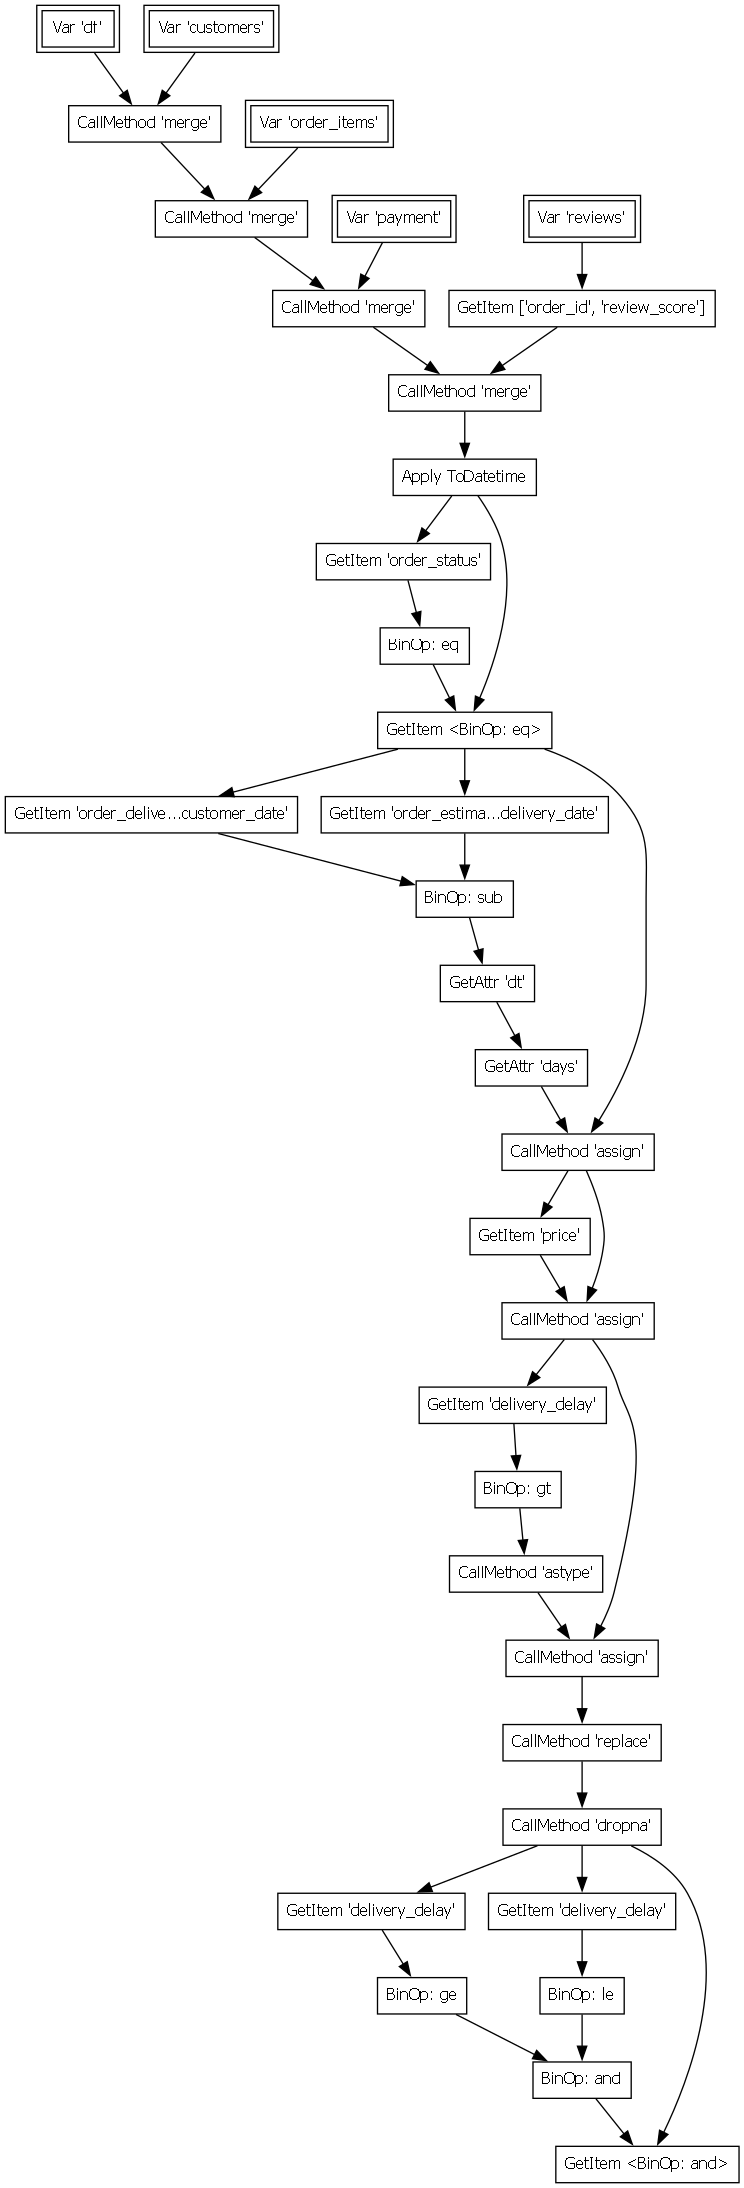

In [5]:
df.skb.draw_graph()

In [6]:
#report = df.skb.full_report()
#report
#display(df["_skrub_provenance_"])
df.head()

<CallMethod 'head'>
Result:
―――――――
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  _prov0                customer_unique_id  \
0                    2017-10-18       0  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18       0  7c396fd4830fd04220f754e42b4e5bff   
2                    2017-10-18       0  7c396fd4830fd04220f754e42b4e5bff   
3                    2018-08-13       1  af07308b275d755c9edb36a90c618231   
4                    2018-09-04       2  3a653a41f6f9fc3d2a113cf8398680e8   

   ...        _prov2 payment_sequential payment_type  payment_installments  \
0  ...  5.629500e+14                1.0  credit_card                   1.0   
1  ...  5.629500e+14                3.0      voucher                   1.0   
2  ...  5.629500e+14                2.0      voucher                   1.0   
3  ...  5.629500e+14                1.0       boleto                   1.0   
4  ...  5.629500e+14                1.0  credit_card                   3.0   

   payment_value        _prov3 review_score delivery_delay  order_value  \
0          18.12  8.444249e+14          4.0           -8.0        29.99   
1           2.00  8.444249e+14          4.0           -8.0        29.99   
2          18.59  8.444249e+14          4.0           -8.0        29.99   
3         141.46  8.444249e+14          4.0           -6.0       118.70   
4         179.12  8.444249e+14          5.0          -18.0       159.90   

   is_delayed  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 30 columns]

In [7]:


# -------------------------------
# 6. Exploratory Data Analysis (EDA)
# -------------------------------
#plt.figure(figsize=(8,5))
#sns.histplot(df["order_value"], bins=50) error: dataop type cannot be interpreted as integer
#plt.title("Order Value Distribution")
#plt.show()

#plt.figure(figsize=(8,5))
#sns.boxplot(x=df["delivery_delay"]) same here
#plt.title("Delivery Delay Distribution (Days)")
#plt.show()

#plt.figure(figsize=(6,4))
#sns.countplot(x="review_score", data=df) Data source must be a DataFrame or Mapping, not <class 'skrub._data_ops._data_ops.DataOp'>.
#plt.title("Review Score Distribution")
#plt.show()

#plt.figure(figsize=(6,4))
#sns.countplot(x="is_delayed", data=df)  Data source must be a DataFrame or Mapping, not <class 'skrub._data_ops._data_ops.DataOp'>.
#plt.title("Delayed vs On-Time Orders")
#plt.show()

# -------------------------------
# 7. Modeling – Classification (Business-Oriented)
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model_df = df.skb.select([
    "freight_value",
    "price",
    "payment_installments",
    "order_value",
    "review_score",
    "is_delayed"
])

#X = model_df.drop("is_delayed", axis=1)
#y = model_df["is_delayed"]
# model_df = model_df.drop("_skrub_provenance_", axis=1)
X = model_df.drop("is_delayed", axis=1).skb.mark_as_X()
y = model_df["is_delayed"].skb.mark_as_y()

#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y, test_size=0.2, random_state=42, stratify=y
#)


In [8]:
X.head()

Column,Column name,dtype,Is sorted,Null values,Unique values,Mean,Std,Min,Median,Max
0,_prov0,Int64DType,True,0 (0.0%),3 (60.0%),0.600,0.894,0,0,2
1,_prov1,Int64DType,False,0 (0.0%),3 (60.0%),2.81e+14,3.21e+04,"281,474,976,711,210","281,474,976,780,952","281,474,976,787,683"
2,price,Float64DType,True,0 (0.0%),3 (60.0%),73.7,61.6,30.0,30.0,160.
3,freight_value,Float64DType,False,0 (0.0%),3 (60.0%),13.6,6.84,8.72,8.72,22.8
4,_prov2,Float64DType,True,0 (0.0%),3 (60.0%),5.63e+14,3.65e+04,5.63e+14,5.63e+14,5.63e+14
5,payment_installments,Float64DType,True,0 (0.0%),2 (40.0%),1.40,0.894,1.00,1.00,3.00
6,_prov3,Float64DType,False,0 (0.0%),5 (100.0%),8.44e+14,3.58e+04,8.44e+14,8.44e+14,8.44e+14
7,review_score,Float64DType,True,0 (0.0%),2 (40.0%),4.20,0.447,4.00,4.00,5.00
8,order_value,Float64DType,True,0 (0.0%),3 (60.0%),73.7,61.6,30.0,30.0,160.


In [9]:

#clf = LogisticRegression(max_iter=1000)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

model = LogisticRegression(max_iter=1000)
clf = X.skb.apply(model, y=y)
split = clf.skb.train_test_split(random_state = 42)
learner = clf.skb.make_learner()
learner.fit(split["train"])
learner.score(split["test"])
y_pred = learner.predict(split["test"])


#print(classification_report(y_test, y_pred))
print(classification_report(split["y_test"], y_pred))

# -------------------------------
# 8. Model Interpretation
# -------------------------------
#coef_df = pd.DataFrame(
 #   learner.coef_[0],
  #  X.columns,
   # columns=["Coefficient"]
#).sort_values(by="Coefficient", ascending=False)

#coef_df
#SADLY, SKRUBLEARNER DOES NOT HAVE .COEF_ ATTRIBUTE, I LOOKED INTO THE DOCUMENTATION
# -------------------------------
# 9. Business Insights
# -------------------------------
"""
Key Insights:
- Higher freight costs significantly increase the probability of delivery delays.
- Payment installments correlate with delayed deliveries, indicating potential operational risk.
- Delayed orders are strongly associated with lower review scores.
- Delivery performance is a critical driver of customer satisfaction.
"""

# -------------------------------
# 10. Conclusion
# -------------------------------
"""
This project presents a realistic e-commerce analytics workflow using 100k+ orders.
By combining multiple datasets, engineering meaningful features, and shifting from
regression to classification, the analysis delivers actionable business insights
focused on logistics performance and customer experience.
"""



              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22759
           1       0.41      0.01      0.01      1800

    accuracy                           0.93     24559
   macro avg       0.67      0.50      0.49     24559
weighted avg       0.89      0.93      0.89     24559



'\nThis project presents a realistic e-commerce analytics workflow using 100k+ orders.\nBy combining multiple datasets, engineering meaningful features, and shifting from\nregression to classification, the analysis delivers actionable business insights\nfocused on logistics performance and customer experience.\n'